<a href="https://colab.research.google.com/github/RufusRubin/YOLO_V1/blob/main/VGG16_YOLO_V1(large_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchsummary
!pip install pretrainedmodels
! pip install torchview
! pip install graphviz

In [ ]:
import os
from collections import Counter
from tqdm import tqdm
import sys
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import models
import pretrainedmodels


from torchview import draw_graph
import graphviz


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from xml.etree import ElementTree as et

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class PotholeDataset(torch.utils.data.Dataset):

    def __init__(self, dir_path, S=7, B=2, C=1, transform=None):

        self.dir_path = dir_path
        self.transform = transform
        self.S = S
        self.C = C
        self.B = B

        self.data= list(sorted(os.listdir(os.path.join(dir_path, "images"))))
        self.annotation= list(sorted(os.listdir(os.path.join(dir_path, "annotations"))))

    def __len__(self):
      return len(self.annotation)


    def __getitem__(self, idx):


        img_path = os.path.join(self.dir_path, "images", self.data[idx])
        ann_path = os.path.join(self.dir_path, "annotations", self.annotation[idx])
        immg_path= os.path.join(self.dir_path, "images")

        #image = Image.open(img_path)


        image = cv2.imread(img_path)
        # convert BGR to RGB color format
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image_resized = cv2.resize(image, (self.width, self.height))
        #image_resized /= 255.0


        labels = []
        boxes = []
        tree = et.parse(ann_path)
        root = tree.getroot()
        
        class_dictionary = {'pothole':0}
        class_dictionary_1 = {'Pothole':0}
        class_dictionary_2 = {'pothole_water':0}
        class_dictionary_3 = {'damage':0}
        class_dictionary_4 = {'crack':0}
        class_dictionary_5 = {'pothole_water_m':0}
                
    
        if(int(root.find('size').find('height').text) != 0):
            filename = root.find('filename').text
            img = Image.open(immg_path + '/' + filename)
            img_width, img_height = img.size
            
            for member in root.findall('object'):
            
                klass = member.find('name').text
                
                if(klass== 'pothole'):
                    
                      klass = class_dictionary[klass]
                      #print("True")
                elif(klass=='Pothole'):
                    
                      klass = class_dictionary_1[klass]
                      #print("false")
                    
                elif(klass=='pothole_water'):
                    
                      klass = class_dictionary_2[klass]
                      #print("false")
                    
                    
                elif(klass=='damage'):
                    
                      klass = class_dictionary_3[klass]
                      #print("false")
                    
                elif(klass=='crack'):
                    
                      klass = class_dictionary_4[klass]
                      #print("false")
                    
                else:
                    
                      klass = class_dictionary_5[klass]
                      #print("false")
                    
                    

                    
                    
                    
                    
                    
                    
            
                # bounding box
                xmin = int(member.find('bndbox').find('xmin').text)
                xmax = int(member.find('bndbox').find('xmax').text)
            
                ymin = int(member.find('bndbox').find('ymin').text)
                ymax = int(member.find('bndbox').find('ymax').text)
                
                centerx = ((xmax + xmin) / 2) / img_width
                centery = ((ymax + ymin) / 2) / img_height
                boxwidth = (xmax - xmin) / img_width
                boxheight = (ymax - ymin) / img_height
            
            
                boxes.append([klass, centerx, centery, boxwidth, boxheight])
            
        elif(int(root.find('size').find('height').text) != 0):
            
            for member in root.findall('object'):
            
                klass = member.find('name').text
                #klass = class_dictionary[klass]   
                
                    
                if(klass== 'pothole'):
                    
                      klass = class_dictionary[klass]
                      #print("True")
                elif(klass=='Pothole'):
                    
                      klass = class_dictionary_1[klass]
                      #print("false")
                    
                elif(klass=='pothole_water'):
                    
                      klass = class_dictionary_2[klass]
                      #print("false")
                    
                    
                elif(klass=='damage'):
                    
                      klass = class_dictionary_3[klass]
                      #print("false")
                    
                elif(klass=='crack'):
                    
                      klass = class_dictionary_4[klass]
                      #print("false")
                    
                else:
                    
                      klass = class_dictionary_5[klass]
                      #print("false")
                    
                    
                    
            
                                # bounding box
                xmin = int(member.find('bndbox').find('xmin').text)
                xmax = int(member.find('bndbox').find('xmax').text)
                img_width = int(root.find('size').find('width').text)
            
                ymin = int(member.find('bndbox').find('ymin').text)
                ymax = int(member.find('bndbox').find('ymax').text)
                img_height = int(root.find('size').find('height').text)
                
                centerx = ((xmax + xmin) / 2) / img_width
                centery = ((ymax + ymin) / 2) / img_height
                boxwidth = (xmax - xmin) / img_width
                boxheight = (ymax - ymin) / img_height
            
            
                boxes.append([klass, centerx, centery, boxwidth, boxheight])




        boxes = torch.Tensor(boxes)

        if self.transform:
          image, boxes = self.transform(image, boxes)


        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))

        for box in boxes:
          class_label, x, y, width, height = box
          class_label = int(class_label)
          i, j = int(self.S * y), int(self.S * x)
          x_cell, y_cell = self.S * x - j, self.S * y - i
          width_cell, height_cell = (
              width * self.S,
              height *self.S,
          )

          if label_matrix[i, j, 1] == 0:
            label_matrix[i, j, 1] = 1 
            box_coordinates = torch.Tensor(
                [x_cell, y_cell, width_cell, height_cell]
            )
            label_matrix[i,j, 2:6] = box_coordinates
            label_matrix[i,j, class_label] = 1

          return image, label_matrix

In [ ]:
dataset= PotholeDataset(dir_path='/kaggle/input/dataset-pothole/dataset_pothole/train')

In [ ]:
x,y =dataset[0]

In [ ]:
x.shape

(768, 1024, 3)

In [ ]:
y.shape

torch.Size([7, 7, 11])

# **Transform**

In [ ]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

    
#orginal dataset
orginal_transform = Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
  
])


#for data augmentation

augmentated_transform = Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406], std=[0.229,0.224,0.225]),
  
])

In [ ]:
dataset= PotholeDataset(dir_path='/kaggle/input/dataset-pothole/dataset_pothole/train',transform= orginal_transform)

In [ ]:
x,y =dataset[0]

In [ ]:
x.shape

torch.Size([3, 299, 299])

In [ ]:
y.shape

torch.Size([7, 7, 11])

# **IOU**

In [ ]:
def intersection_over_union(boxes_pred, boxes_labels, box_format = "midpoint"):

  if box_format == "midpoint":
    box1_x1 = boxes_pred[..., 0:1] - boxes_pred[..., 2:3]/2
    box1_y1 = boxes_pred[..., 1:2] - boxes_pred[..., 3:4]/2
    box1_x2 = boxes_pred[..., 0:1] + boxes_pred[..., 2:3]/2
    box1_y2 = boxes_pred[..., 1:2] + boxes_pred[..., 3:4]/2
    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3]/2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4]/2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3]/2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4]/2

  elif box_format == "corners":
    box1_x1 = boxes_pred[..., 0:1]
    box1_y1 = boxes_pred[..., 1:2]
    box1_x2 = boxes_pred[..., 2:3]
    box1_y2 = boxes_pred[..., 3:4]
    box2_x1 = boxes_labels[..., 0:1]
    box2_y1 = boxes_labels[..., 1:2]
    box2_x2 = boxes_labels[..., 2:3]
    box2_y2 = boxes_labels[..., 3:4]

  x1 = torch.max(box1_x1, box2_x1)
  y1 = torch.max(box1_y1, box2_y1)
  x2 = torch.min(box1_x2, box2_x2)
  y2 = torch.min(box1_y2, box2_y2)

  intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
#   print(intersection)

  box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
  box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

  union  = box1_area + box2_area -intersection

  return intersection/(union + 1e-6)

# **NMS**

In [ ]:
def non_max_suppression(bboxes,iou_threshold,prob_threshold,box_format = "corners"):
  
  assert type(bboxes) == list

  bboxes = [box for box in bboxes if box[1] > prob_threshold]
  bboxes = sorted(bboxes, key=lambda x : x[1], reverse = True)
  bboxes_aft_nms = []

  while bboxes:
    chosen_box = bboxes.pop(0)

    bboxes = [
              box for box in bboxes
              if box[0] != chosen_box[0]
              or intersection_over_union(
                  torch.Tensor(chosen_box[2:]),
                  torch.Tensor(box[2:]),
                  box_format = box_format
              ) < iou_threshold
    ]

    bboxes_aft_nms.append(chosen_box)

  return bboxes_aft_nms

In [ ]:
def convert_cellboxes(predictions, S=7, C=1):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, C + 10)
    bboxes1 = predictions[..., C + 1:C + 5]
    bboxes2 = predictions[..., C + 6:C + 10]
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C + 5].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 5]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds

In [ ]:
def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

# **VISUALIZE THE IMAGE**

In [ ]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    cmap = plt.get_cmap("tab20b")
    class_labels = 'Pothole'
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle patch
    for box in boxes:
      
        assert len(box) == 6, "box should contain class pred, confidence, x, y, width, height"
        class_pred = box[0]
        conf = box[1]
        box = box[2:]
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle((upper_left_x * width, upper_left_y * height),box[2] * width,box[3] * height,linewidth=2,edgecolor=colors[int(class_pred)],facecolor="none")
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.text(upper_left_x,upper_left_y ,s=class_labels[int(class_pred)] + ': ' + str(conf),color="white",verticalalignment="top",bbox={"color": colors[int(class_pred)], "pad": 0})

    plt.show()

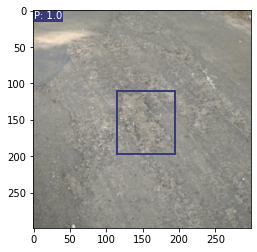

In [ ]:
S = [7]
dataset= PotholeDataset(dir_path='/kaggle/input/dataset-pothole/dataset_pothole/train', transform= orginal_transform)
loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)
for x, y in loader:
    boxes = []

    for i in range(y[0].shape[1]):

        boxes+= cellboxes_to_boxes(y)[0]
    boxes = non_max_suppression(boxes, iou_threshold=1, prob_threshold=0.7,  box_format="midpoint")
    plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)
    #area_image(x[0].permute(1, 2, 0).to("cpu"), boxes)
    break

# **YOLO LOSS**

In [ ]:
class yololoss(nn.Module):
  def __init__(self, S = 7, B = 2, C = 1):
    super(yololoss, self).__init__()
    self.mse = nn.MSELoss(reduction="sum")
    self.S = S
    self.B = B
    self.C = C
    self.lambda_coord = 5
    self.lambda_noobj = 0.5

  def forward(self, prediction, target):
    prediction = prediction.reshape(-1, self.S, self.S, self.C + self.B * 5)
#     print(prediction.shape)

    iou_b1 = intersection_over_union(prediction[...,2:6], target[...,2:6])
    iou_b2 = intersection_over_union(prediction[...,7:11], target[...,2:6])

    ious = torch.cat([iou_b1.unsqueeze(0),iou_b2.unsqueeze(0)], dim =0)
    iou_maxes, best_box = torch.max(ious, dim=0)
    exists_box = target[..., 1].unsqueeze(3) #Iobj_i
    
    if torch.sum(best_box) > 1:
        best_box = 1
    else:
        best_box = 0
    ####  BOX LOSS  ####
    #Box-Coordinates (mid-point, width & height)
    box_predictions = exists_box * (
        (
            best_box * prediction[...,7:11]
            + (1 - best_box) * prediction[...,2:6]
        )
    )

    box_targets = exists_box * target[...,2:6]

    box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
        torch.abs(box_predictions[..., 2:4] + 1e-6)
    )
    
    #box dimensions: (N, S, S, 6)
    box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])
    #(N, S, S, 4) -> (N*S*S, 4)
    box_loss = self.mse(torch.flatten(box_predictions, end_dim=-2),
                        torch.flatten(box_targets, end_dim=-2),
                        )
    
    #### OBJECT LOSS ####
    pred_box = (
        best_box * prediction[..., 6:7] + (1 - best_box) * prediction[...,1:2]
    )
    # (N,S,S,1) -> (N*S*S*1)
    object_loss = self.mse(
        torch.flatten(exists_box * pred_box),
        torch.flatten(exists_box * target[...,1:2])
    )

    #### NO-OBJECT LOSS ####
    #(N, S, S, 1) -> (N, S*S*1)
    no_object_loss = self.mse(
        torch.flatten((1 - exists_box) * prediction[..., 1:2], start_dim=1),
        torch.flatten((1 - exists_box) * target[..., 1:2], start_dim=1),
    )

    no_object_loss = self.mse(
        torch.flatten((1 - exists_box) * prediction[..., 6:7], start_dim=1),
        torch.flatten((1 - exists_box) * target[..., 1:2], start_dim=1),
    )

    class_loss = self.mse(
        torch.flatten(exists_box * prediction[...,:1], end_dim = -2),
        torch.flatten(exists_box * target[...,:1], end_dim = -2)
    )

    loss = (
        self.lambda_coord * box_loss 
        + object_loss
        + self.lambda_noobj * no_object_loss
        + class_loss
    )

    return loss


# **MAP**

In [ ]:
def mean_average_precision(pred_boxes, true_boxes, iou_threshold = 0.5, box_format="corners", num_classes=1):

  #pred_boxes_format = [[train_id, class_prob, box_prob, x1, y1, x2, y2], ...]
  average_precisions = []
    
  epsilon = 1e-6

  for c in range(num_classes):
    detections = []
    ground_truths = []

    for detection in pred_boxes:
      if detection[1] == c:
        detections.append(detection)

    for true_box in true_boxes:
      if true_box[1] == c:
        ground_truths.append(true_box)

    amount_boxes = Counter([gt[0] for gt in ground_truths])
    
    for key, val in amount_boxes.items():
      amount_boxes[key] = torch.zeros(val)

    detections.sort(key = lambda x: x[2], reverse = True)
    TP = torch.zeros((len(detections)))
    FP = torch.zeros((len(detections)))
    total_true_bboxes = len(ground_truths)

    for detection_idx, detection in enumerate(detections):
      ground_truth_img = [
              bbox for bbox in ground_truths  if bbox[0] == detection[0]
                   ]

      num_gts = len(ground_truth_img)
      best_iou = 0

      for idx, gt in enumerate(ground_truth_img):
        iou = intersection_over_union(
            torch.Tensor(detection[3:]),
            torch.Tensor(gt[3:]),
            box_format = box_format,
            )
        
        if iou > best_iou:
          best_iou = iou
          best_gt_idx = idx

      if best_iou > iou_threshold:

        if amount_boxes[detection[0]][best_gt_idx] == 0:
            TP[detection_idx] = 1
            amount_boxes[detection[0]][best_gt_idx] = 1
        else:
            FP[detection_idx] = 1
       
      else:
        FP[detection_idx] = 1 

    TP_cumsum = torch.cumsum(TP, dim=0)
    FP_cumsum = torch.cumsum(FP, dim=0)
    recalls = TP_cumsum / (total_true_bboxes + epsilon)
    precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
    precisions = torch.cat((torch.tensor([1]), precisions))
    recalls = torch.cat((torch.tensor([0]), recalls))
    average_precisions.append(torch.trapz(precisions, recalls))

  return sum(average_precisions) / len(average_precisions), sum(average_precisions)



# **GET_BBOXES**

In [ ]:
def get_bboxes(loader,model,iou_threshold,threshold,pred_format="cells",box_format="midpoint",device=device):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                prob_threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

# **YOLO-V1 MODEL**

In [ ]:
original_model = models.vgg16(pretrained=True)
original_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
class vgg16(nn.Module):
            def __init__(self,split_size, num_boxes, num_classes):
                super(vgg16, self).__init__()
                
                S, B, C = split_size, num_boxes, num_classes
                
                self.features = nn.Sequential(
                    # stop at conv4
                    *list(original_model.features.children())[0:31]
                )
                
                self.avgpool= nn.AdaptiveAvgPool2d((7,7))
                self.flatten= nn.Flatten()
                self.linear_1= nn.Linear(512 * S * S, 512)
                self.dropout= nn.Dropout(0.0)
                self.leakyrelu= nn.LeakyReLU(0.1)
                self.linear_2= nn.Linear(512, S * S *(C + B * 5))
                
                
            def forward(self, x):
                x = self.features(x)
                x=self.avgpool(x)
                x= self.flatten(x)
                x=self.linear_1(x)
                x=self.dropout(x)
                x=self.leakyrelu(x)
                x=self.linear_2(x)
                return x

In [ ]:
model = vgg16(split_size = 7, num_boxes=2, num_classes = 1).to(device)
print(model)

vgg16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [ ]:
model = vgg16(split_size = 7, num_boxes=2, num_classes = 1).to(device)
summary(model, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 299, 299]           1,792
              ReLU-2         [-1, 64, 299, 299]               0
            Conv2d-3         [-1, 64, 299, 299]          36,928
              ReLU-4         [-1, 64, 299, 299]               0
         MaxPool2d-5         [-1, 64, 149, 149]               0
            Conv2d-6        [-1, 128, 149, 149]          73,856
              ReLU-7        [-1, 128, 149, 149]               0
            Conv2d-8        [-1, 128, 149, 149]         147,584
              ReLU-9        [-1, 128, 149, 149]               0
        MaxPool2d-10          [-1, 128, 74, 74]               0
           Conv2d-11          [-1, 256, 74, 74]         295,168
             ReLU-12          [-1, 256, 74, 74]               0
           Conv2d-13          [-1, 256, 74, 74]         590,080
             ReLU-14          [-1, 256,

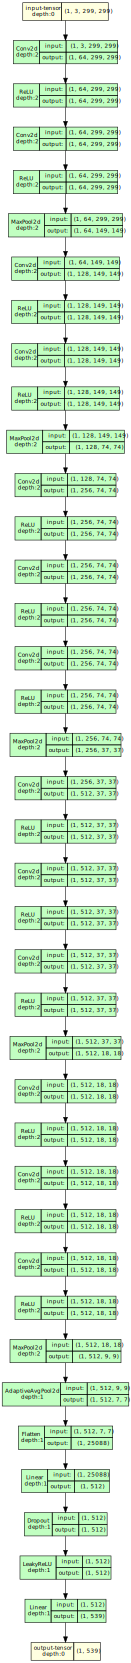

In [ ]:
model_plot = draw_graph(model, input_size=(1,3,299,299))
model_plot.visual_graph

In [ ]:
def test(S = 7, B = 2, C = 1):
  model = vgg16(split_size = S, num_boxes=B, num_classes = C).to(device)
  x = torch.randn((1, 3, 299, 299)).to(device)
  print(model(x).shape)

test()


torch.Size([1, 539])


# **OPTIMIZER AND LOSS**

In [ ]:
lr = 0.0001
BATCH_SIZE = 8
WEIGHT_DECAY = 0.00005
save_path = "vgg16_yolo_v1.pth"
fine_tune = True
load_path = "/kaggle/input/vgg16-yolo-v1-weight/vgg16_yolo_v1.pth"

In [ ]:
loss_fn = yololoss()

model = vgg16(split_size = 7, num_boxes=2, num_classes = 1).to(device)

#optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=WEIGHT_DECAY)

optimizer= optim.SGD(model.parameters(), lr= lr, momentum= 0.9, weight_decay=WEIGHT_DECAY)


# **WEIGHT LOADING**

In [ ]:
state_dict = torch.load(load_path, map_location=device)
model.load_state_dict(state_dict)

<All keys matched successfully>

# **TRAINING FUNCTION**

In [ ]:
def train(model,dataloader):    
    # training function

    print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    for batch, (X, y) in enumerate(tqdm(dataloader)):


        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()



    loss = running_loss/len(dataloader)

    print('Train Loss: %.3f'%(loss))

    return loss

# **VALIDATION FUNCTION**

In [ ]:
#validation function
def validate(model, dataloader):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)
            running_loss += loss_fn(pred, y).item()        

        
        loss = running_loss/len(dataloader)

        print('Test Loss: %.3f '%(loss))
        
        return loss 

# **LOAD DATA**

In [ ]:
orginal_train_dataset = PotholeDataset(dir_path='/kaggle/input/dataset-pothole/dataset_pothole/train',transform = orginal_transform)

augmented_train_dataset = PotholeDataset(dir_path='/kaggle/input/dataset-pothole/dataset_pothole/train', transform = augmentated_transform)

train_data = torch.utils.data.ConcatDataset([orginal_train_dataset,augmented_train_dataset])

print(len(train_data))


orginal_test_dataset = PotholeDataset(dir_path='/kaggle/input/dataset-pothole/dataset_pothole/test', transform = orginal_transform)

augmented_test_dataset = PotholeDataset(dir_path='/kaggle/input/dataset-pothole/dataset_pothole/test',transform = augmentated_transform)

test_data = torch.utils.data.ConcatDataset([orginal_test_dataset,augmented_test_dataset])

print(len(test_data))




3194
504


# **DATA LOADER**

In [ ]:
train_loader = DataLoader(dataset = train_data,batch_size = BATCH_SIZE,shuffle=True,num_workers=4,drop_last = True)

test_loader = DataLoader(dataset = test_data,batch_size = BATCH_SIZE,shuffle=True, num_workers=4, drop_last = True)


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
epochs= 50



train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []

train_mAP,val_mAP=[],[]
train_precisions, val_precisions= [],[]
train_recalls, val_recalls= [],[]
train_average_precisions, val_average_precisions= [],[]


print(f"Training on {len(train_data)} examples, validating on {len(test_data)} examples...")


for epoch in range(epochs):
    
      print(f"Epoch {epoch+1} of {epochs}")

      # training

      train_epoch_loss = train(model, train_loader)
      train_loss.append(train_epoch_loss)

      #validation


      val_epoch_loss = validate(model, test_loader)
      val_loss.append(val_epoch_loss)


pred_boxes, target_boxes = get_bboxes(train_loader, model, iou_threshold=0.5, threshold=0.4)
mean_avg_prec, average_precisions = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
print(f"Train mAP: {mean_avg_prec}")
print(f"Train average_precisions: {average_precisions}")


pred_boxes, target_boxes = get_bboxes(test_loader, model, iou_threshold=0.5, threshold=0.4)
mean_avg_prec, average_precisions = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
print(f"Val mAP: {mean_avg_prec}")
print(f"Val average_precisions: {average_precisions}")



Training on 3194 examples, validating on 504 examples...
Epoch 1 of 50
Training


100%|██████████| 399/399 [02:04<00:00,  3.20it/s]

Train Loss: 0.110
Validating


Test Loss: 0.130 
Epoch 2 of 50
Training


100%|██████████| 399/399 [02:10<00:00,  3.06it/s]

Train Loss: 0.095
Validating


Test Loss: 0.147 
Epoch 3 of 50
Training


100%|██████████| 399/399 [02:13<00:00,  2.99it/s]

Train Loss: 0.087
Validating


Test Loss: 0.159 
Epoch 4 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.98it/s]

Train Loss: 0.083
Validating


Test Loss: 0.194 
Epoch 5 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.97it/s]

Train Loss: 0.078
Validating


Test Loss: 0.216 
Epoch 6 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.96it/s]

Train Loss: 0.075
Validating


Test Loss: 0.219 
Epoch 7 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.96it/s]

Train Loss: 0.072
Validating


Test Loss: 0.258 
Epoch 8 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.96it/s]

Train Loss: 0.070
Validating


Test Loss: 0.262 
Epoch 9 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.97it/s]

Train Loss: 0.067
Validating


Test Loss: 0.268 
Epoch 10 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.97it/s]

Train Loss: 0.066
Validating


Test Loss: 0.294 
Epoch 11 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.97it/s]

Train Loss: 0.064
Validating


Test Loss: 0.299 
Epoch 12 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.96it/s]

Train Loss: 0.063
Validating


Test Loss: 0.315 
Epoch 13 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.98it/s]

Train Loss: 0.061
Validating


Test Loss: 0.337 
Epoch 14 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.96it/s]

Train Loss: 0.059
Validating


Test Loss: 0.347 
Epoch 15 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.97it/s]

Train Loss: 0.059
Validating


Test Loss: 0.357 
Epoch 16 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.96it/s]

Train Loss: 0.058
Validating


Test Loss: 0.379 
Epoch 17 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.96it/s]

Train Loss: 0.057
Validating


Test Loss: 0.408 
Epoch 18 of 50
Training


100%|██████████| 399/399 [02:15<00:00,  2.95it/s]

Train Loss: 0.056
Validating


Test Loss: 0.391 
Epoch 19 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.96it/s]

Train Loss: 0.055
Validating


Test Loss: 0.396 
Epoch 20 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.96it/s]

Train Loss: 0.054
Validating


Test Loss: 0.426 
Epoch 21 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.96it/s]

Train Loss: 0.053
Validating


Test Loss: 0.426 
Epoch 22 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.96it/s]

Train Loss: 0.053
Validating


Test Loss: 0.448 
Epoch 23 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.97it/s]

Train Loss: 0.052
Validating


Test Loss: 0.468 
Epoch 24 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.97it/s]

Train Loss: 0.051
Validating


Test Loss: 0.457 
Epoch 25 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.97it/s]

Train Loss: 0.051
Validating


Test Loss: 0.503 
Epoch 26 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.97it/s]

Train Loss: 0.050
Validating


Test Loss: 0.496 
Epoch 27 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.97it/s]

Train Loss: 0.049
Validating


Test Loss: 0.488 
Epoch 28 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.98it/s]

Train Loss: 0.049
Validating


Test Loss: 0.510 
Epoch 29 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.97it/s]

Train Loss: 0.048
Validating


Test Loss: 0.528 
Epoch 30 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.97it/s]

Train Loss: 0.048
Validating


Test Loss: 0.537 
Epoch 31 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.98it/s]

Train Loss: 0.047
Validating


Test Loss: 0.539 
Epoch 32 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.97it/s]

Train Loss: 0.047
Validating


Test Loss: 0.565 
Epoch 33 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.97it/s]

Train Loss: 0.046
Validating


Test Loss: 0.588 
Epoch 34 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.97it/s]

Train Loss: 0.046
Validating


Test Loss: 0.594 
Epoch 35 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.96it/s]

Train Loss: 0.045
Validating


Test Loss: 0.606 
Epoch 36 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.97it/s]

Train Loss: 0.045
Validating


Test Loss: 0.613 
Epoch 37 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.97it/s]

Train Loss: 0.044
Validating


Test Loss: 0.592 
Epoch 38 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.96it/s]

Train Loss: 0.044
Validating


Test Loss: 0.633 
Epoch 39 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.96it/s]

Train Loss: 0.043
Validating


Test Loss: 0.630 
Epoch 40 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.96it/s]

Train Loss: 0.043
Validating


Test Loss: 0.656 
Epoch 41 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.96it/s]

Train Loss: 0.043
Validating


Test Loss: 0.666 
Epoch 42 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.96it/s]

Train Loss: 0.042
Validating


Test Loss: 0.661 
Epoch 43 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.96it/s]

Train Loss: 0.042
Validating


Test Loss: 0.696 
Epoch 44 of 50
Training


100%|██████████| 399/399 [02:15<00:00,  2.95it/s]

Train Loss: 0.042
Validating


Test Loss: 0.680 
Epoch 45 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.97it/s]

Train Loss: 0.042
Validating


Test Loss: 0.680 
Epoch 46 of 50
Training


100%|██████████| 399/399 [02:15<00:00,  2.95it/s]

Train Loss: 0.041
Validating


Test Loss: 0.714 
Epoch 47 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.97it/s]

Train Loss: 0.041
Validating


Test Loss: 0.738 
Epoch 48 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.97it/s]

Train Loss: 0.041
Validating


Test Loss: 0.716 
Epoch 49 of 50
Training


100%|██████████| 399/399 [02:14<00:00,  2.97it/s]

Train Loss: 0.041
Validating


Test Loss: 0.722 
Epoch 50 of 50
Training


100%|██████████| 399/399 [02:13<00:00,  2.98it/s]

Train Loss: 0.040
Validating


Test Loss: 0.740 
Train mAP: 0.9999906420707703
Train average_precisions: 0.9999906420707703
Val mAP: 0.9683106541633606
Val average_precisions: 0.9683106541633606


In [ ]:
torch.save(model.state_dict(), save_path)
print("Saved PyTorch Model State to model.pth")


Saved PyTorch Model State to model.pth


In [ ]:
model = vgg16(split_size = 7, num_boxes=2, num_classes = 1).to(device)
state_dict = torch.load(f"/kaggle/working/{save_path}")
model.load_state_dict(state_dict)

test_dataset = PotholeDataset(dir_path='/kaggle/input/dataset-pothole/dataset_pothole/test', transform = orginal_transform)

test_loader = DataLoader(dataset = test_dataset,batch_size = BATCH_SIZE,shuffle=True,drop_last = True)

pred_boxes, target_boxes = get_bboxes(test_loader, model, iou_threshold=0.5, threshold=0.4)


mean_avg_prec, average_precisions = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
print(f"Test mAP: {mean_avg_prec}")
print(f"Test average_precisions: {average_precisions}")

Test mAP: 0.9626123309135437
Test average_precisions: 0.9626123309135437


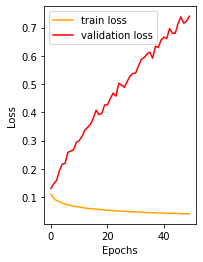

In [ ]:

# loss plots
plt.subplot(122)
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('../outputs/plots/loss.png')
plt.show()

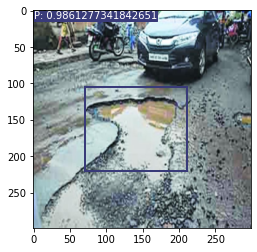

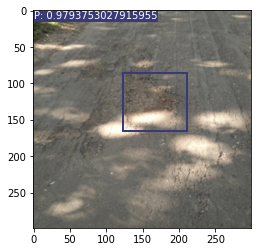

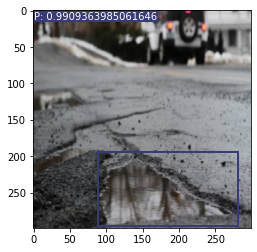

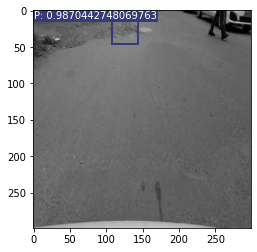

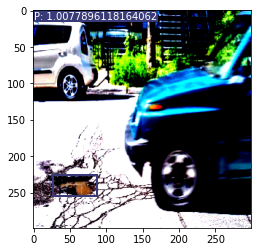

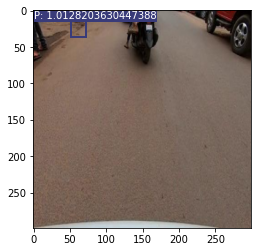

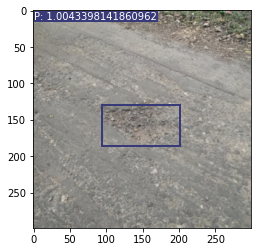

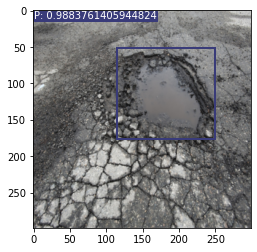

SystemExit: 

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3560: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
for epoch in range(4):
    for x, y in train_loader:
       x = x.to(device)
       for idx in range(8):
           bboxes = cellboxes_to_boxes(model(x))
           bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.4, prob_threshold=0.5, box_format="midpoint")
           plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)
           #area_image(x[idx].permute(1, 2, 0).to("cpu"), bboxes)

       import sys
       sys.exit()

In [ ]:
for epoch in range(4):
    for x, y in test_loader:
       x = x.to(device)
       for idx in range(8):
           bboxes = cellboxes_to_boxes(model(x))
           bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, prob_threshold=0.4, box_format="corners")
           plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)
           #area_image(x[idx].permute(1, 2, 0).to("cpu"), bboxes)

       import sys
       sys.exit()